In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random
random.seed(46)

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(46)

# Progress bar
from tqdm.auto import tqdm

from implementations_NB04 import*

# MLP for mandatory lane change prediction
## Reading the data 

In [2]:
InitialInput=pd.read_csv('input_files/Initial_input.csv')
fd_monday=pd.read_csv('input_files/congestion_results_monday.csv')
fd_tuesday=pd.read_csv('input_files/congestion_results_tuesday.csv')
fd_wednesday=pd.read_csv('input_files/congestion_results_wednesday.csv')
fd_thursday=pd.read_csv('input_files/congestion_results_thursday.csv')

In [3]:
x_monday = fd_monday[['Entry time [s]','Flow 1 [veh/min]','Density 1 [veh/m]','Congestion index 1','Flow 2 [veh/min]','Density 2 [veh/m]','Congestion index 2','Flow 3 [veh/min]','Density 3 [veh/m]','Congestion index 3']].to_numpy(dtype=float)
x_tuesday = fd_tuesday[['Entry time [s]','Flow 1 [veh/min]','Density 1 [veh/m]','Congestion index 1','Flow 2 [veh/min]','Density 2 [veh/m]','Congestion index 2','Flow 3 [veh/min]','Density 3 [veh/m]','Congestion index 3']].to_numpy(dtype=float)
x_wednesday = fd_wednesday[['Entry time [s]','Flow 1 [veh/min]','Density 1 [veh/m]','Congestion index 1','Flow 2 [veh/min]','Density 2 [veh/m]','Congestion index 2','Flow 3 [veh/min]','Density 3 [veh/m]','Congestion index 3']].to_numpy(dtype=float)
x_thursday = fd_thursday[['Entry time [s]','Flow 1 [veh/min]','Density 1 [veh/m]','Congestion index 1','Flow 2 [veh/min]','Density 2 [veh/m]','Congestion index 2','Flow 3 [veh/min]','Density 3 [veh/m]','Congestion index 3']].to_numpy(dtype=float)

x_FD=np.concatenate((x_monday,x_tuesday,x_wednesday,x_thursday),axis=0)
#x_FD.shape = (9429, 10)

## Outlier Detection
### k-NN

In [4]:
##adding a column that will help find the outliers

data=InitialInput[[
     "Avg_speed",
     "Nbr_LaneChange" , "Avg_Acc_tan" , "Avg_Acc_lat"]].to_numpy(dtype=float)

X=pd.DataFrame(data)

knn = NearestNeighbors(n_neighbors = 10)
x = X
mean= x.mean( axis=0)
std= x.std(axis=0)
x=(x-mean)/std
knn.fit(x)
dist, _ = knn.kneighbors(x)

results=InitialInput.copy()
results[f'mean_dist_knn'] = dist.mean(axis=1)

threshold=0.5
InitialInput['knn'] = results[f'mean_dist_knn'] > threshold

## Preparing the data for the NN

In [5]:
x1 = InitialInput[[    
    "Track_ID", "Class", "Destination", "Origin", "Avg_speed",
    "Total_distance", "Nbr_LaneChange" , "Avg_Acc_tan" , "Avg_Acc_lat", "knn"  
    ]].to_numpy(dtype=float)

x_full=np.concatenate((x1,x_FD),axis=1)

y_full = InitialInput[["Track_ID", "Distance_last_lane",]].to_numpy(dtype=float)

print(x_full.shape,y_full.shape)

(9429, 20) (9429, 2)


In [6]:
#removes the vehicule with no MC -> distance = 0
ind_nodist = np.where(y_full[:,1]==0)
x_mc = np.delete(x_full,ind_nodist,axis=0)
y_mc = np.delete(y_full,ind_nodist,axis=0)
print(f'{x_mc.shape[0]} vehicles have a mandatory lane change. \n')

#remove the outliers from Knn
indice_outliers= np.where(x_mc[:,9]==1)
x_Outliers = np.delete(x_mc,indice_outliers,axis=0)
y_Outliers = np.delete(y_mc,indice_outliers,axis=0)
x_Outliers = np.delete(x_Outliers,(9),axis=1)
print(f'Removing the outliers retains {x_Outliers.shape[0]} vehicles. \n')

#removes the motorcycles, bus and heavy vehicles
ind_moto = np.where(x_Outliers[:,1]==3) 
ind_bus = np.where(x_Outliers[:,1]==4) 
ind_heavy = np.where(x_Outliers[:,1]==6) 
ind_remove = np.concatenate((ind_moto,ind_bus,ind_heavy),axis=1)
x = np.delete(x_Outliers,ind_remove,axis=0)
y = np.delete(y_Outliers,ind_remove,axis=0)
print(f'Removing the motorcycles, bus and heavy vehicles retains {x.shape[0]} vehicles. \n')

x_train, x_test, y_train, y_test = separation_test_day(x, y)
print(f'We split the data with {x_train.shape[0]} vehicles for training and {x_test.shape[0]} vehicles for testing')
test_id = y_test[:,0] #for the output at the end
test_id.shape = (-1,1)

1853 vehicles have a mandatory lane change. 

Removing the outliers retains 1649 vehicles. 

Removing the motorcycles, bus and heavy vehicles retains 1276 vehicles. 

We split the data with 924 vehicles for training and 352 vehicles for testing


In [7]:
#normalization
mean_x = x_train.mean(axis=0) ; std_x = x_train.std(axis=0)
mean_y = y_train.mean(axis=0) ; std_y = y_train.std(axis=0)
x_train = (x_train-mean_x)/std_x ; x_test = (x_test-mean_x)/std_x
y_train = (y_train-mean_y)/std_y ; y_test = (y_test-mean_y)/std_y

std_y = std_y[1:] #don't take the first one because it's ID
mean_y = mean_y[1:]

## Neural Net

MLP Neural Net 

Here is the general pipeline used to train neural networks with PyTorch:

```
1. Load the dataset
2. Initialize a dataloader, define data transforms
3. Define and instantiate network architecture
4. Choose a loss function
5. Choose an optimizer (incl. learning rate, weight decay & momentum)
6. Define the training loop & number of epochs
7. Train the model
```

## Initialization

In [8]:
# passing the data to torch
train_data = np.concatenate((x_train, y_train), axis=1) ; test_data = np.concatenate((x_test, y_test), axis=1)
train_data = torch.from_numpy(train_data) ; test_data = torch.from_numpy(test_data)

In [9]:
batch_size = 16
#Reshuffle training data at every epoch, but not the test data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
class FourLayerNet(nn.Module):
    """4-Layer neural net"""
    """3 Hidden-Layer neural net"""
    
    def __init__(self):
        super().__init__()     
        self.fc1 = nn.Linear(18, 50)
        self.fc2 = nn.Linear(50, 300)
        self.fc3 = nn.Linear(300,10)
        self.fc4 = nn.Linear(10,1)
        self.norm1= nn.BatchNorm1d(num_features=18, eps=1e-08, momentum=0.1)
        self.norm2= nn.BatchNorm1d(num_features=50, eps=1e-08, momentum=0.1)
        self.norm3= nn.BatchNorm1d(num_features=300, eps=1e-08, momentum=0.1)
        self.drop = nn.Dropout(p=0.2)
        self.apply(self._init_weights)       

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0, std=1/np.sqrt(18))
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.norm1(x)
        x = F.relu(self.fc1(x))
        x = self.norm2(x)
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.norm3(x)
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        return out

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        pred = self.forward(x)
        return pred

model = FourLayerNet()

In [11]:
#loss function, optimizer & scheduler
loss_fn = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.000001) 
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.9)

In [12]:
def train(model: torch.nn.Module,train_loader: torch.utils.data.DataLoader,loss_fn: torch.nn.Module,optimizer: torch.optim.Optimizer, epochs: int):
    loss_metric = LossMetric()# Initialize metrics for loss and accuracy
    
    model.train() # Sets the module in training mode
    
    for epoch in range(1, epochs + 1):
        
        # Progress bar set-up
        pbar = tqdm(total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
       
        for data in train_loader:  # Iterate through data         
            X_train = data[:, 1:19].reshape(-1, 18) # separate inputs and output 
            y_train = data[:, 20:].reshape(-1, 1) #without track ID
         
            optimizer.zero_grad() # Zero-out the gradients          
            
            out = model(X_train.float()) # Forward pass           
           
            loss = loss_fn(out.float(), y_train.float()) # Compute loss            
          
            loss.backward() # Backward pass
                       
            optimizer.step() # Optimizer step
            
            loss_metric.update(loss.item(), data.shape[0]) # Update metrics & progress bar
            pbar.update()
        scheduler.step() 
            
        # End of epoch, show loss and acc
        pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f}")
        loss_metric.reset()

In [13]:
# Model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t \t \t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 	 	 torch.Size([50, 18])
fc1.bias 	 	 	 torch.Size([50])
fc2.weight 	 	 	 torch.Size([300, 50])
fc2.bias 	 	 	 torch.Size([300])
fc3.weight 	 	 	 torch.Size([10, 300])
fc3.bias 	 	 	 torch.Size([10])
fc4.weight 	 	 	 torch.Size([1, 10])
fc4.bias 	 	 	 torch.Size([1])
norm1.weight 	 	 	 torch.Size([18])
norm1.bias 	 	 	 torch.Size([18])
norm1.running_mean 	 	 	 torch.Size([18])
norm1.running_var 	 	 	 torch.Size([18])
norm1.num_batches_tracked 	 	 	 torch.Size([])
norm2.weight 	 	 	 torch.Size([50])
norm2.bias 	 	 	 torch.Size([50])
norm2.running_mean 	 	 	 torch.Size([50])
norm2.running_var 	 	 	 torch.Size([50])
norm2.num_batches_tracked 	 	 	 torch.Size([])
norm3.weight 	 	 	 torch.Size([300])
norm3.bias 	 	 	 torch.Size([300])
norm3.running_mean 	 	 	 torch.Size([300])
norm3.running_var 	 	 	 torch.Size([300])
norm3.num_batches_tracked 	 	 	 torch.Size([])


In [14]:
train(model, train_loader, loss_fn, optimizer, epochs=7)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [15]:
PATH = "modelFourLayerNet.pt"
torch.save(model.state_dict(), PATH)

In [16]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    loss_metric = LossMetric()
    
    pbar = tqdm(total=len(test_loader), leave=True) # Progress bar set-up
      
    model.eval() # Sets the module in eval mode
    
    with torch.no_grad():
        
        for data in dataloader: # Iterate through data
            X_test = data[:, 1:19].reshape(-1, 18)
            y_test = data[:, 20:].reshape(-1, 1)
        
            out = model(X_test.float()) # Forward pass
            
            loss = loss_fn(out.float(), y_test.float())
            
            loss_metric.update(loss.item(), data.shape[0])
   
            pbar.update() # Update progress bar
            
    # End of epoch, show loss and acc
    test_loss = loss_metric.compute() * 100
    pbar.set_postfix_str(f"Loss: {test_loss:.2f}")
    return test_loss

In [17]:
test_loss = test(model, test_loader)
print(f'Error of {np.sqrt(test_loss):.2f} meters')

  0%|          | 0/22 [00:00<?, ?it/s]

Error of 6.71 meters


## Visualisation of the predictions

In [18]:
#The predictions are normalized, need to undo the normalization to have values in a correct range
pred_norm = model.predict(torch.from_numpy(x_test[:, 1:19]).float())
pred = (pred_norm.detach().numpy()*std_y+mean_y) #un-normalization of the outputs
outputs = np.concatenate((test_id,pred),axis=1)
outputs_df = pd.DataFrame(outputs)
#outputs_df.to_csv('outputs_from_NN.csv') #lr = 0.05 | gamma = 0.125 | 7 epochs | weight_decay = 0.01

In [19]:
#Comparing the mean and std of the prediction and the true values
print(f'Comparison of the mean : true values -> {mean_y[0]}, predictions -> {np.mean(pred)} ')
print(f'Comparison of the std : true values -> {std_y[0]}, predictions -> {np.std(pred)} ')

Comparison of the mean : true values -> 48.43624615225172, predictions -> 49.33443215990575 
Comparison of the std : true values -> 47.390727094260114, predictions -> 30.362081310787566 


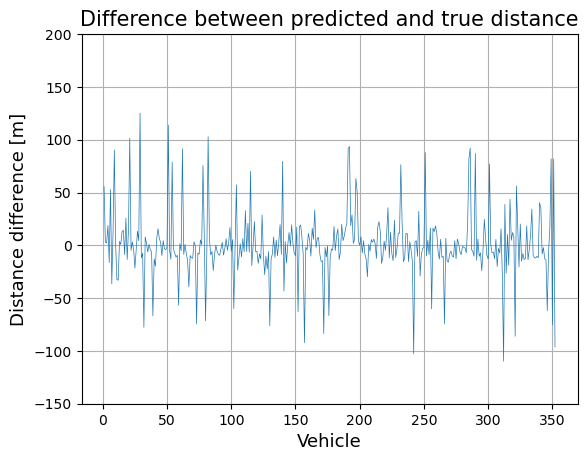

In [20]:
#Difference between true and predicted distance in meters
y_test_unnorm = (y_test*std_y+mean_y)[:,1]
y_test_unnorm.shape = (-1,1)
diff = pred-y_test_unnorm

plt.figure
plt.plot(np.arange(1,len(pred)+1,1),diff,linewidth=.5)
plt.title("Difference between predicted and true distance", fontsize=15)
plt.ylim([-150, 200])
plt.grid()
plt.xlabel("Vehicle", fontsize=13)
plt.ylabel("Distance difference [m]", fontsize=13)
#plt.savefig("plots/DifferenceInDistance.png")
plt.show()


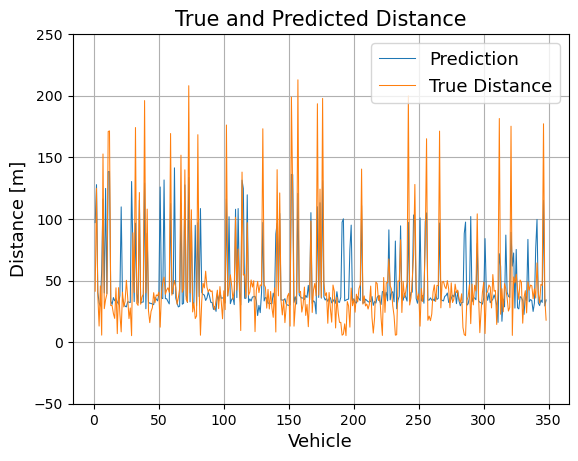

In [21]:
Nmin = 0 #int between 0 and 347
Nmax = 348 #int between 1 and 348
plt.figure
plt.plot(np.arange(1,len(pred[Nmin:Nmax])+1,1),pred[Nmin:Nmax],linewidth=.75)
plt.plot(np.arange(1,len(pred[Nmin:Nmax])+1,1),y_test_unnorm[Nmin:Nmax],linewidth=.75)
plt.title("True and Predicted Distance", fontsize=15)
plt.grid()
plt.ylim([-50, 250])
plt.legend(["Prediction","True Distance"], fontsize=13)
plt.xlabel("Vehicle", fontsize=13)
plt.ylabel("Distance [m]", fontsize=13)
#plt.savefig("plots/TrueAndPredictedDistance.png")
plt.show()